# Optimization Project 2
## Stock Portfolio

## Team

<pre>
<b>Name:</b> Manideep Telukuntla     <b>UT EID:</b> mt39528
<b>Name:</b> Krittika Deshwal        <b>UT EID:</b> kd29275
<b>Name:</b> Milind Bhatia           <b>UT EID:</b> mb67324
<b>Name:</b> Chih-En Ko              <b>UT EID:</b> ck29388
</pre>

### Time Limit Variable

In [1]:
time_limit = 3600

In [2]:
# import statements
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates

In [3]:
# Function to identify date column
def identify_date_column(df):
    for col in df.columns:
        try:
            # Try converting the column to datetime
            pd.to_datetime(df[col], errors='coerce')
            
            # Check the number of NaT values (unparsed dates)
            valid_dates = df[col].notna().sum()
            
            # If more than 80% of the values are valid dates, return the column name
            if valid_dates / len(df) > 0.8:
                return col
        except Exception:
            pass
    return None

## Specific 1

Two csv files are included with this assignment. One of those files contains daily prices of the
index as well as the component stocks of the NASDAQ-100 in 2019. The first column is the date,
the second column is the index price (NDX), and columns 3-102 are the prices of the component
stocks. The second file is the same, except it’s 2020 prices. (We are using pre- and post-
shutdown data to see if anything fishy happens!) There were actually 103 stocks in the NASDAQ-
100 in 2020, but 3 of them are new stocks that don’t have data for all of 2019, so I just removed
them. You’re going to use the 2019 file for all your portfolio construction tasks and then analyze
the performance on the 2020 file; that is, how well does your portfolio, constructed with 2019
data, track the index in 2020? When we grade your assignment, we will use different csv files
with potentially a different number of days and a different index with a different number of
component stocks. You will need to calculate the returns of the stocks in the 2019 file to
calculate the correlation matrix for stock selection and weight construction, and you will need
the returns of the index for weight construction. You will also need the daily returns in 2020 for
both the index and the stocks to evaluate the performance of your portfolio in 2020. Use the
correlation matrix of returns as 𝜌.

### Data Preprocessing

In [4]:
# Load datasets
stock2019 = pd.read_csv('stocks2019.csv')
stock2020 = pd.read_csv('stocks2020.csv')

# Identify and set the date column as index
date_column_2019 = identify_date_column(stock2019)
date_column_2020 = identify_date_column(stock2020)

if not date_column_2019 or not date_column_2020:
    raise ValueError("A date column was not identified in one of the dataframes.")

stock2019.set_index(date_column_2019, inplace=True)
stock2020.set_index(date_column_2020, inplace=True)

# The first column is the index column
index_column = stock2019.columns[0]
stock_columns = stock2019.columns.drop(index_column)

# Compute returns
return2019 = stock2019[stock_columns].pct_change().dropna()
return2020 = stock2020[stock_columns].pct_change().dropna()
index_return2019 = stock2019[index_column].pct_change().dropna()
index_return2020 = stock2020[index_column].pct_change().dropna()

In [5]:
return2019.corr()

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
ATVI,1.000000,0.399939,0.365376,0.223162,0.216280,0.433097,0.426777,0.467076,0.203956,0.329355,...,0.322906,0.128241,0.464850,0.316549,0.259679,0.218149,0.311659,0.303077,0.043389,0.249667
ADBE,0.399939,1.000000,0.452848,0.368928,0.363370,0.552125,0.540404,0.598237,0.291978,0.473815,...,0.360392,0.201151,0.711339,0.541243,0.402171,0.228106,0.650430,0.361516,0.207403,0.289497
AMD,0.365376,0.452848,1.000000,0.301831,0.344252,0.418861,0.417254,0.549302,0.151452,0.503733,...,0.332776,0.210623,0.498342,0.330900,0.272983,0.281950,0.407626,0.438892,0.017283,0.478010
ALXN,0.223162,0.368928,0.301831,1.000000,0.332433,0.315993,0.307698,0.363170,0.342022,0.317040,...,0.257143,0.408936,0.350581,0.191489,0.522423,0.192720,0.416396,0.289908,0.047947,0.200356
ALGN,0.216280,0.363370,0.344252,0.332433,1.000000,0.248747,0.250316,0.399281,0.264599,0.328280,...,0.175957,0.128559,0.360886,0.251855,0.334978,0.219595,0.308968,0.284407,0.088059,0.253934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WBA,0.218149,0.228106,0.281950,0.192720,0.219595,0.232900,0.230603,0.288168,0.194490,0.347861,...,0.257049,0.145330,0.195475,0.126118,0.214585,1.000000,0.211641,0.296309,-0.130798,0.276643
WDAY,0.311659,0.650430,0.407626,0.416396,0.308968,0.379493,0.371826,0.424748,0.211712,0.351734,...,0.235045,0.269545,0.569672,0.401476,0.376047,0.211641,1.000000,0.315699,0.209240,0.254117
WDC,0.303077,0.361516,0.438892,0.289908,0.284407,0.328619,0.322110,0.419620,0.172623,0.602935,...,0.377215,0.126463,0.331916,0.308558,0.314773,0.296309,0.315699,1.000000,-0.076115,0.516958
XEL,0.043389,0.207403,0.017283,0.047947,0.088059,0.059930,0.052570,0.076724,0.137857,-0.047259,...,-0.172752,0.074686,0.280371,0.407770,0.191667,-0.130798,0.209240,-0.076115,1.000000,-0.117552


### Checking variations between 2019 and 2020 index returns

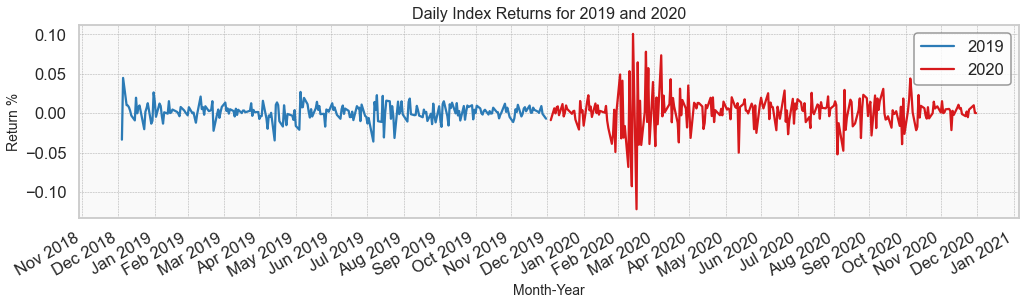

In [29]:
# Convert the indices of both dataframes to a consistent datetime format without time
index_return2019.index = pd.to_datetime(index_return2019.index).date
index_return2020.index = pd.to_datetime(index_return2020.index).date

# Combine the dataframes
combined_returns = pd.concat([index_return2019, index_return2020], axis=1)
combined_returns.columns = ['2019', '2020']

# Setting up the figure and axis
plt.figure(figsize=(15, 4))
ax = plt.gca()

# Colors
line_color_2019 = '#2c7bb6'  # Soft blue
line_color_2020 = '#d7191c'  # Soft red

# Plot daily returns
plt.plot(combined_returns.index, combined_returns['2019'], linestyle='-', color=line_color_2019, label='2019')
plt.plot(combined_returns.index, combined_returns['2020'], linestyle='-', color=line_color_2020, label='2020')

# Styling and annotations
plt.title('Daily Index Returns for 2019 and 2020', fontsize=16)
plt.xlabel('Month-Year', fontsize=14)
plt.ylabel('Return %', fontsize=14)
plt.legend(frameon=True, edgecolor='gray')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='#aaaaaa')
ax.set_facecolor('#f9f9f9')

# Formatting the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) # 'b' gives abbreviated month name
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=-1)) # Set locator to the end of each month

plt.tight_layout()
plt.gcf().autofmt_xdate() # Rotate the labels for better clarity
# plt.savefig('DailyIndexReturns.png', dpi=300, bbox_inches='tight')
plt.show()

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="arial" size="4"> 

From the above graph, the volatility in returns of 2019 are relatively stable when we compare them to the returns of 2020 data. One possible explaination could easily be uncertain market conditions that existed during the early days of pandemic. 

Let's see how our portfolio performs given the volatility between the two years.

</font>
</div>



## Specific 2

Start with m=5. Find the best 5 stocks to include in your portfolio and the weights of those 5
stocks, using the 2019 data. How well does this portfolio track the index in 2020? That is,
calculate ∑ |𝑞𝑡− ∑ 𝑤𝑖𝑟 𝑖𝑡
5
𝑖=1 |𝑇
𝑡=1 using the 2020 data (except wi is from your 2019 solution…).

In [7]:
def select_stocks_with_maximum_correlation(return_data, max_stocks=5):
    """
    Select stocks based on maximizing the total correlation.
    
    Parameters:
    - return_data (DataFrame): The stock return data.
    - max_stocks (int): Maximum number of stocks to select. Default is 5.
    
    Returns:
    - List of selected stock names.
    - Maximized total correlation.
    """
    # Compute correlations
    correlation_matrix = return_data.corr()
    n = return_data.shape[1]
    m = min(max_stocks, n)
    
    # Setup gurobi model
    model = gp.Model()
    
    # Decision variables
    x = model.addVars(n, n, vtype='B')
    y = model.addVars(n, vtype='B')
    
    # Set objective to maximize total correlation
    model.setObjective(gp.quicksum(correlation_matrix.iloc[i, j] * x[i, j] for i in range(n) for j in range(n)), sense=GRB.MAXIMIZE)
    
    # Add constraints
    model.addConstr(gp.quicksum(y[j] for j in range(n)) == m)
    model.addConstrs(gp.quicksum(x[i, j] for j in range(n)) == 1 for i in range(n))
    model.addConstrs(x[i, j] <= y[j] for i in range(n) for j in range(n))
    
    # Supress gurobi output
    model.Params.OutputFlag = 0
    
    # Optimize the model
    model.optimize()
    
    selected_stocks = [correlation_matrix.columns[j] for j in range(n) if y[j].X == 1]
    
    return selected_stocks, model.objVal

# Usage
return_data = return2019
selected_stocks, max_correlation = select_stocks_with_maximum_correlation(return_data)
print(f"\nThe stocks we chose are: {', '.join(selected_stocks)}")
print(f"Max correlation total would be: {max_correlation:.4f}")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-20

The stocks we chose are: LBTYK, MXIM, MSFT, VRTX, XEL
Max correlation total would be: 54.8399


In [8]:
def determine_optimal_weights_and_forecast_error(return_data, selected_stocks, index_return, next_year_return_data, next_year_index_return):
    """
    Determine the optimal weights for the selected stocks to minimize tracking error and 
    calculate forecast errors for the next year.
    
    Parameters:
    - return_data (DataFrame): The stock return data.
    - selected_stocks (list): List of selected stock names.
    - index_return (Series): The return of the index.
    - next_year_return_data (DataFrame): The stock return data for the next year.
    - next_year_index_return (Series): The return of the index for the next year.
    
    Returns:
    - Training error.
    - Testing error.
    - Dictionary of optimal weights for the selected stocks.
    """
    # Determine optimal weights for the selected stocks
    return_set = return_data[selected_stocks]
    T = len(return_set)
    m = len(selected_stocks)
    
    # Setup gurobi model
    model = gp.Model()
    
    # Decision variables
    w = model.addVars(m)
    z = model.addVars(T)
    
    # Set objective to minimize error
    model.setObjective(gp.quicksum(z[t] for t in range(T)), sense=GRB.MINIMIZE)
    
    # Add constraints
    model.addConstr(gp.quicksum(w[i] for i in range(m)) == 1)
    model.addConstrs(z[t] >= (index_return.iloc[t] - gp.quicksum(w[i] * return_set.iloc[t, i] for i in range(m))) for t in range(T))
    model.addConstrs(z[t] >= -(index_return.iloc[t] - gp.quicksum(w[i] * return_set.iloc[t, i] for i in range(m))) for t in range(T))
    
    # Supress gurobi output
    model.Params.OutputFlag = 0 
    
    # Optimize the model
    model.optimize()
    
    weights = {return_set.columns[i]: w[i].X for i in range(m)}
    
    # Calculate forecast errors for the next year
    return_set_next = next_year_return_data[selected_stocks]
    T_next = len(return_set_next)
    testing_error = sum(abs(next_year_index_return.iloc[t] - sum(w[i].X * return_set_next.iloc[t, i] for i in range(m))) for t in range(T_next))
    
    return model.objVal, testing_error, weights

# Usage
return_data = return2019
training_error, testing_error, optimal_weights = determine_optimal_weights_and_forecast_error(return_data, selected_stocks, index_return2019, return2020, index_return2020)
print(f"\nTraining error would be: {training_error:.4f}")
print(f"Testing error would be: {testing_error:.4f}\n")
for stock, weight in optimal_weights.items():
    print(f"The weight for {stock} is: {weight:.4f}")


Training error would be: 0.7892
Testing error would be: 1.1124

The weight for LBTYK is: 0.0489
The weight for MXIM is: 0.2104
The weight for MSFT is: 0.5804
The weight for VRTX is: 0.0712
The weight for XEL is: 0.0892


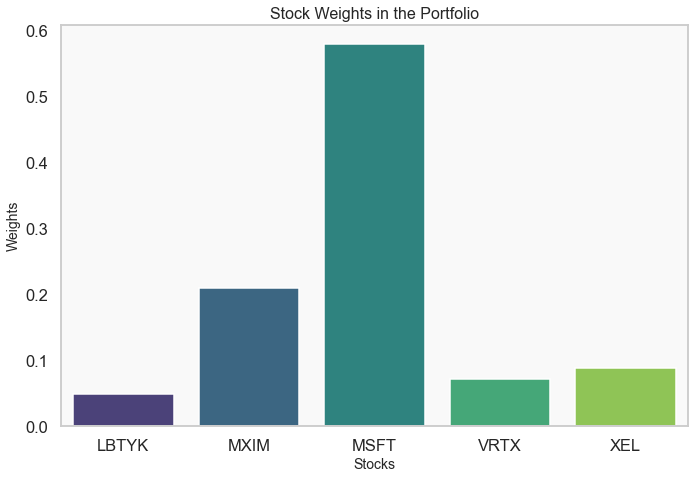

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract stocks and weights from the optimal_weights dictionary
stocks = list(optimal_weights.keys())
weights = list(optimal_weights.values())

# Setting the overall aesthetic.
sns.set_style("whitegrid", {'axes.grid': False, 'grid.color': '#aaaaaa'})
sns.set_context("talk")  # "talk" context is good for larger plots

# Create a Seaborn bar plot with custom colors
plt.figure(figsize=(10, 7))
bar = sns.barplot(x=stocks, y=weights, palette='viridis')  # You can choose different color palettes

# Styling and annotations
bar.set_title('Stock Weights in the Portfolio', fontsize=16)
bar.set_xlabel('Stocks', fontsize=14)
bar.set_ylabel('Weights', fontsize=14)

# Setting the background color
bar.set_facecolor('#f9f9f9')
plt.tight_layout()
# plt.savefig('StockWeights.png', dpi=300, bbox_inches='tight')
plt.show()

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="arial" size="4"> 

Upon solving this problem, below are the 5 stocks that we chose along with their weights:

- The weight for LBTYK is: 0.0489
- The weight for MXIM is: 0.2104
- The weight for MSFT is: 0.5804
- The weight for VRTX is: 0.0712
- The weight for XEL is: 0.0892

The training error using this approach was 0.7892 and the test error was 1.1124. This essentially means that our built portfolio tracks 2020 index decently given we only picked 5 stocks out of the 100 stocks present in the index.
 
</font>
</div>



## Specific 3

Redo step (2) with m = 10, 20, …, 90, 100 (obviously when m=100 you don’t need to solve for
which stocks to include, because they’re all included). Analyze the performance of the portfolio
for each value of m. How does the performance change? Is there some value of m, where there
are diminishing returns of including more stocks in the portfolio? You can also look at the in-
sample performance. That is, evaluate the performance in 2019 using 2019 portfolio
construction and 2019 data. How is performance in 2019 different than performance in 2020?
Why is it different? Be sure to write your code so that if there are more or fewer than 100
stocks in the csv file it stops at the right place.

In [10]:
def optimize_portfolio(return2019, return2020, index_return2019, index_return2020):
    """
    Optimize the portfolio based on stock selection and weight allocation.
    """
    
    error_2019 = []
    error_2020 = []
    results = []

    n = len(return2019.columns)
    for m_val in range(10, min(101, n+1), 10):
        print(f"\n\nOptimizing for m_value = {m_val}")
        print('-' * 80)

        # Use the first function to select stocks
        selected_stocks, max_correlation = select_stocks_with_maximum_correlation(return2019, m_val)

        # Use the updated function to determine optimal weights for 2019 data and forecast error for 2020
        training_error, testing_error, optimal_weights_2019 = determine_optimal_weights_and_forecast_error(return2019, selected_stocks, index_return2019, return2020, index_return2020)
        error_2019.append(training_error)
        error_2020.append(testing_error)

        # Display selected stocks and their weights as a DataFrame
        display_df = pd.DataFrame(list(optimal_weights_2019.items()), columns=['Selected Stocks', 'Weights']).set_index('Selected Stocks')
        print(display_df)
        print()

        # Print the rest of the details
        print(f"Max correlation for 2019: {max_correlation:.4f}")
        print(f"Training error for 2019: {training_error:.4f}")
        print(f"Testing error for 2020: {testing_error:.4f}")
        print('-' * 80)

        # Collect results for CSV
        results.append({
            'm_value': m_val,
            'Selected Stocks': ', '.join(selected_stocks),
            'Weights': ', '.join([f'{stock}: {weight:.4f}' for stock, weight in optimal_weights_2019.items()]),
            'Max Correlation 2019': max_correlation,
            'Training Error 2019': training_error,
            'Testing Error 2020': testing_error
        })

    # Save all results to a single CSV
    df = pd.DataFrame(results)
    df.to_csv("portfolio_optimization_results.csv", index=False)

    return error_2019, error_2020

# Call the function with given datasets
errors_2019, errors_2020 = optimize_portfolio(return2019, return2020, index_return2019, index_return2020)

print("\n\nCompleted Portfolio Optimization!")
print(f"Training Errors for 2019: {errors_2019}")
print(f"\nTesting Errors for 2020: {errors_2020}")

#Adding m=5 errors into this lost for future comparison of methods
errors_2019_comp = [training_error] + errors_2019
errors_2020_comp = [testing_error] + errors_2020



Optimizing for m_value = 10
--------------------------------------------------------------------------------
                  Weights
Selected Stocks          
ATVI             0.044200
ALGN             0.024996
EXPE             0.021501
KHC              0.023389
LBTYK            0.037835
MXIM             0.156986
MSFT             0.491031
ROST             0.091152
VRTX             0.046216
XEL              0.062695

Max correlation for 2019: 59.3319
Training error for 2019: 0.7012
Testing error for 2020: 1.1024
--------------------------------------------------------------------------------


Optimizing for m_value = 20
--------------------------------------------------------------------------------
                  Weights
Selected Stocks          
ATVI             0.024613
ALGN             0.012773
GOOGL            0.204352
ANSS             0.074454
ADP              0.019414
BIIB             0.006517
CMCSA            0.045297
DLTR             0.019957
EXPE             0.007310
J

                  Weights
Selected Stocks          
ATVI             0.008611
AMD              0.006453
ALXN             0.001588
ALGN             0.008199
GOOGL            0.096784
...                   ...
VRTX             0.007505
WBA              0.009550
WDAY             0.000251
XEL              0.000000
XLNX             0.016468

[80 rows x 1 columns]

Max correlation for 2019: 95.7289
Training error for 2019: 0.1477
Testing error for 2020: 0.5373
--------------------------------------------------------------------------------


Optimizing for m_value = 90
--------------------------------------------------------------------------------
                  Weights
Selected Stocks          
ATVI             0.003441
ADBE             0.020015
AMD              0.004609
ALXN             0.003648
ALGN             0.000023
...                   ...
WBA              0.008059
WDAY             0.001399
WDC              0.002064
XEL              0.007810
XLNX             0.007687

[90 rows x

In [11]:
port_opt_result = pd.read_csv('portfolio_optimization_results.csv')

# Calculate the Percentage Deviation and add it as a new column
port_opt_result["Percentage Deviation"] = ((port_opt_result["Testing Error 2020"] - port_opt_result["Training Error 2019"]) / port_opt_result["Training Error 2019"]) * 100

# Select and display the desired columns, including the new column
selected_columns = port_opt_result[["m_value", "Max Correlation 2019", "Training Error 2019", "Testing Error 2020", "Percentage Deviation"]]
selected_columns

,m_value,Max Correlation 2019,Training Error 2019,Testing Error 2020,Percentage Deviation
0,10,59.331930,0.701218,1.102404,57.212838
1,20,66.648075,0.478836,0.899598,87.871823
2,30,72.696797,0.418015,0.769110,83.991200
3,40,78.259157,0.370517,0.791047,113.498097
4,50,83.316268,0.332540,0.772100,132.182427
5,60,87.877505,0.344890,1.097304,218.160475
6,70,92.062402,0.169824,0.557854,228.490213
7,80,95.728853,0.147683,0.537323,263.836384
8,90,98.517121,0.053779,0.367790,583.888179
9,100,100.000000,0.044911,0.368671,720.895462


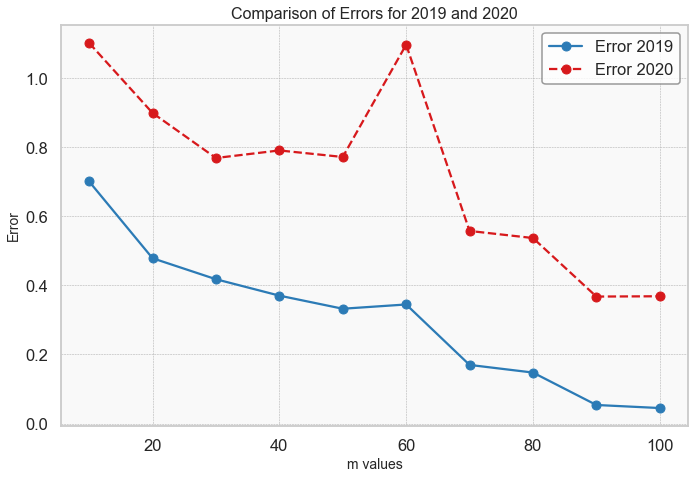

In [12]:
n = len(return2019.columns)
m_list = list(range(10, min(101, n+1), 10))

# Setting up the figure and axis
plt.figure(figsize=(10, 7))
ax = plt.gca()

# Colors
line_color_2019 = '#2c7bb6'  # Soft blue
line_color_2020 = '#d7191c'  # Soft red

# Plotting for 2019
plt.plot(m_list, errors_2019, marker='o', linestyle='-', color=line_color_2019, label='Error 2019')

# Plotting for 2020
plt.plot(m_list, errors_2020, marker='o', linestyle='--', color=line_color_2020, label='Error 2020')

# Styling and annotations
plt.xlabel('m values', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title('Comparison of Errors for 2019 and 2020', fontsize=16)
plt.legend(frameon=True, edgecolor='gray')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='#aaaaaa')
ax.set_facecolor('#f9f9f9')

plt.tight_layout()
plt.show()

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="arial" size="4"> 

The above output displays the performance of our portfolio upon increase the number of stocks from 10 - 100. We observed that as we increase the number of stocks in our portfolio our training and test error continues to go down. Our training error goes down from 0.7 all the way down to 0.04. 
Since the model was training on 2019 data, we will consider test error i.e., 2020 error data to be more accurate which goes down from 1.1 to 0.36.

We do see a spike in the test error at m=60 which maybe because of an unexpected scenario in 2020 such as COVID. This difference brings us back to our above insights where we noticed difference in returns volatility between 2019 and 2020.
 
</font>
</div>



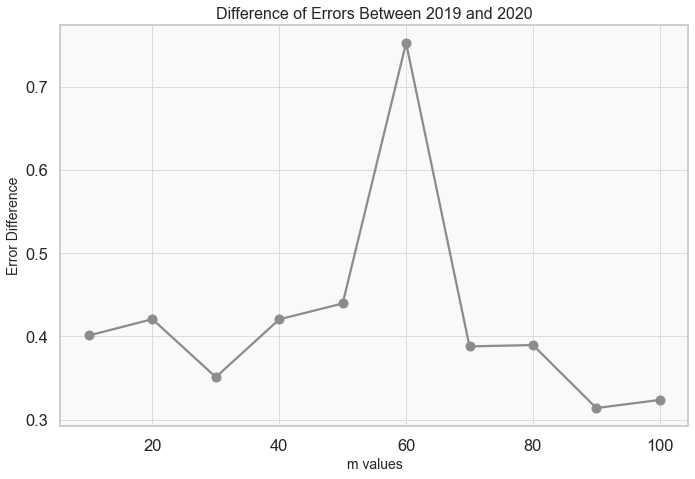

In [13]:
import numpy as np
import matplotlib.pyplot as plt

error_diff = abs(np.subtract(errors_2020, errors_2019))

# Setting up the figure and axis
plt.figure(figsize=(10, 7))
ax = plt.gca()

# Color
line_color_diff = '#8c8c8c'  # Soft gray

# Plotting for error difference
plt.plot(m_list, error_diff, marker='o', linestyle='-', color=line_color_diff)

# Styling and annotations
plt.xlabel('m values', fontsize=14)
plt.ylabel('Error Difference', fontsize=14)
plt.title('Difference of Errors Between 2019 and 2020', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='#aaaaaa')
ax.set_facecolor('#f9f9f9')

plt.tight_layout()
plt.show()

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="arial" size="4"> 

Similar to our above insights, the difference between our training and testing errors are pretty consistent except for a spike. In this scenario, our portfolio may have included some stocks in 2019 which had an unexpected impact due to covid. However, this is our hypothesis and we do not have factual data to back on it as of now.
 
</font>
</div>



## Specific 4

Another way you could solve this problem is to completely ignore the stock selection IP and re-
formulate the weight selection problem to be an MIP that constrains the number of non-zero
weights to be an integer. To do this take the weight selection problem and replace m with n so
that you are optimizing over ALL weights: min
𝑤
∑ |𝑞𝑡− ∑ 𝑤𝑖𝑟𝑖𝑡
𝑛
𝑖=1 |
𝑇
𝑡=1. Now define some
binary variables y1, y2, …, yn and add some constraints that force wi = 0 if yi = 0 using the ‘big M’
technique (What’s the smallest value of big M you could use?). You also need to add a
constraint that the sum of y’s is equal to m (m and M are different things here…). It turns out
that this is a VERY hard problem for gurobi to solve. After 24 hours running on my desktop
gurobi didn’t find a solution! We can force gurobi to quit looking for a solution after a specific
amount of time by setting the TimeLimit value, in units of seconds, in the params list (the place
where we tell gurobi to shut up). Redo parts 2 and 3 with this new method to find weights. For
each value of m, limit gurobi to work for 1 hour. Which method works better on the 2020 data,
the original method or this new method? Note that your code will need to run for up to 10
hours to create your final output. I would suggest that you plan ahead and set this to run
overnight. You can set your Python file to save your results for this part to a csv file, and then
you can also have it check to see if that csv file exists, if it exists grab those results without
spending the 10 hours, and if it doesn’t then re-solve the problem. That way you only have to
do the big solution once and you can still work on the formatting of your Python file. In your
Python file create a clearly obvious variable at the top, that is equal to 3600, that you reference
to limit gurobi’s time. This way when we grade your solutions, we can set it to something
smaller to make sure your code works without having to wait 10 hours for everyone’s code to
run.

In [14]:
def calculate_error(weights, return_set, index_return):
    """
    Calculate the error for the given weights, return set, and index return.

    Parameters:
    - weights: List of float values representing portfolio weights.
    - return_set: DataFrame representing stock returns.
    - index_return: DataFrame representing index returns.

    Returns:
    - error: Float value representing the calculated error.
    """
    T = len(return_set)
    error = sum(abs(index_return.iloc[t] - sum(weights[i] * return_set.iloc[t,i] for i in range(len(weights)))) for t in range(T))
    return error

def optimize_portfolio_for_m(return_set, index_return, m, n, M, time_limit):
    """
    Optimize the portfolio for a given m (number of stocks to select).

    Parameters:
    - return_set: DataFrame representing stock returns.
    - index_return: DataFrame representing index returns.
    - m: Integer value representing the number of stocks to select.
    - n: Total number of available stocks.
    - M: Large positive number for the optimization model.
    - time_limit: Time limit for the optimization model.

    Returns:
    - selected_stocks: List of strings representing the selected stocks.
    - weights: List of float values representing the optimal weights for the selected stocks.
    - error: Float value representing the error of the optimized portfolio for the training data.
    """
    model = gp.Model()

    T = len(return_set)
    w = model.addVars(n)
    y = model.addVars(n, vtype='B')
    z = model.addVars(T)

    model.setObjective(gp.quicksum(z[t] for t in range(T)), sense=GRB.MINIMIZE)
    model.addConstr(gp.quicksum(w[i] for i in range(n)) == 1)
    model.addConstr(gp.quicksum(y[i] for i in range(n)) == m)
    model.addConstrs(w[i] <= M * y[i] for i in range(n))
    model.addConstrs(z[t] >= (index_return.iloc[t] - gp.quicksum(w[i] * return_set.iloc[t,i] for i in range(n))) for t in range(T))
    model.addConstrs(z[t] >= -(index_return.iloc[t] - gp.quicksum(w[i] * return_set.iloc[t,i] for i in range(n))) for t in range(T))

    model.Params.TimeLimit = time_limit
    model.Params.OutputFlag = 0 
    model.optimize()

    selected_stocks = [return_set.columns[i] for i in range(n) if y[i].X == 1]
    weights = [w[i].X for i in range(n) if y[i].X == 1]
    
    return selected_stocks, weights, model.ObjVal

def print_results(m, selected_stocks, weights, error2019, error2020):
    """
    Print the results in a table format.

    Parameters:
    - m: Integer representing the number of selected stocks.
    - selected_stocks: List of strings representing the selected stocks.
    - weights: List of float values representing the weights of the selected stocks.
    - error2019: Float value representing the error for 2019.
    - error2020: Float value representing the error for 2020.

    Returns:
    - None. Prints the results.
    """
    print(f"\nResults for m={m}:")
    print("-" * 50)
    print("{:<20} {:<20}".format("Stock", "Weight"))
    print("-" * 50)
    for stock, weight in zip(selected_stocks, weights):
        print("{:<20} {:<20.6f}".format(stock, weight))
    print("-" * 50)
    print(f"Error 2019: {error2019:.6f}")
    print(f"Error 2020: {error2020:.6f}")
    print("-" * 50)

def save_weights_to_csv(results, file_path):
    """
    Save the weights to a CSV file.

    Parameters:
    - results: DataFrame containing the optimization results.
    - file_path: String representing the path to save the CSV file.

    Returns:
    - None. The results are saved to a CSV file.
    """
    all_stocks = results['selected_stocks'].explode().unique()
    weight_df = pd.DataFrame(index=results['m'], columns=all_stocks).fillna(0)

    for index, row in results.iterrows():
        for stock, weight in zip(row['selected_stocks'], row['weights']):
            weight_df.loc[row['m'], stock] = weight

    weight_df['Total Weight'] = weight_df.sum(axis=1)
    weight_df.to_csv(file_path, index_label='m')

def optimize_all(return2019, return2020, index_return2019, index_return2020, n, M, time_limit, file_path, weights_file_path):
    """
    Optimize the portfolio for a range of m values, print results and save to CSV files.

    Parameters:
    - ... [All the same parameters as the previous function]

    Returns:
    - None. The results are printed and saved to CSV files.
    """
    results = pd.DataFrame(columns=['m', 'selected_stocks', 'weights', 'error_2019', 'error_2020'])
    
    m_values = [5] + [i for i in range(10, min(101, n+1), 10)]
    
    for m_val in m_values:
        m = min(m_val, n)
        selected_stocks, weights, error2019 = optimize_portfolio_for_m(return2019, index_return2019, m, n, M, time_limit)
        error2020 = calculate_error(weights, return2020[selected_stocks], index_return2020)
        print_results(m, selected_stocks, weights, error2019, error2020)

        new_row = {'m': m, 'selected_stocks': selected_stocks, 'weights': weights, 'error_2019': error2019, 'error_2020': error2020}
        results.loc[len(results)] = new_row

    results.to_csv(file_path, index=False)
    save_weights_to_csv(results, weights_file_path)

In [ ]:
M = 1 # Since our weights are between 0 and 1, the smalled bigM is 1
# Function call
optimize_all(return2019, return2020, index_return2019, index_return2020, n, M, time_limit, 'output.csv', 'weights.csv')

In [24]:
output = pd.read_csv('output.csv') #reading file which we ran 3600 seconds per loop
output

,m,selected_stocks,weights,error_2019,error_2020
0,5,"['AMZN', 'ADI', 'AAPL', 'MSFT', 'MDLZ']","[0.25012259799984393, 0.11375807105291455, 0.1...",0.499259,0.777362
1,10,"['GOOGL', 'AMZN', 'AMGN', 'AAPL', 'FB', 'INTC'...","[0.09350273277588875, 0.12580811985444165, 0.0...",0.290137,0.753372
2,20,"['ADBE', 'GOOGL', 'AMZN', 'AMGN', 'AAPL', 'ADP...","[0.03965063582581233, 0.08673323276085017, 0.0...",0.164639,0.579404
3,30,"['ADBE', 'AMD', 'ALXN', 'GOOG', 'AMZN', 'AMGN'...","[0.039541427154617, 0.008936426123727343, 0.00...",0.114082,0.505220
4,40,"['ADBE', 'AMD', 'GOOGL', 'AMZN', 'AMGN', 'AAPL...","[0.02545418559181543, 0.004913584548981473, 0....",0.082215,0.435368
5,50,"['ATVI', 'ADBE', 'AMD', 'ALXN', 'GOOG', 'AMZN'...","[0.00689728021092901, 0.025821934861864602, 0....",0.065023,0.385733
6,60,"['ATVI', 'ADBE', 'AMD', 'GOOGL', 'AMZN', 'AMGN...","[0.0022107880863217982, 0.021939986989190974, ...",0.052651,0.361089
7,70,"['ATVI', 'ADBE', 'AMD', 'GOOGL', 'AMZN', 'AMGN...","[0.0028154831209198485, 0.018330258040311128, ...",0.047488,0.360502
8,80,"['ATVI', 'ADBE', 'AMD', 'ALXN', 'GOOGL', 'GOOG...","[0.003119274021157583, 0.01784450654012397, 0....",0.045227,0.370629
9,90,"['ATVI', 'ADBE', 'AMD', 'ALXN', 'GOOGL', 'GOOG...","[0.004223289593193418, 0.017140049274028263, 0...",0.044911,0.368682


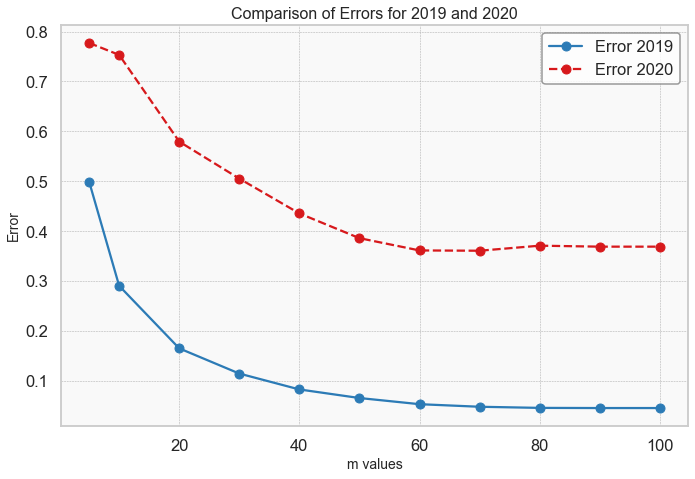

In [25]:
# Setting up the figure and axis
plt.figure(figsize=(10, 7))
ax = plt.gca()

# Colors
line_color_2019 = '#2c7bb6'  # Soft blue
line_color_2020 = '#d7191c'  # Soft red

# Plotting for 2019
plt.plot(output['m'], output['error_2019'], marker='o', linestyle='-', color=line_color_2019, label='Error 2019')

# Plotting for 2020
plt.plot(output['m'], output['error_2020'], marker='o', linestyle='--', color=line_color_2020, label='Error 2020')

# Styling and annotations
plt.xlabel('m values', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title('Comparison of Errors for 2019 and 2020', fontsize=16)
plt.legend(frameon=True, edgecolor='gray')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='#aaaaaa')
ax.set_facecolor('#f9f9f9')

plt.tight_layout()

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="arial" size="4"> 

The output from our new approach seem to be better than our original approach as our test error in much lower. Morever, our test error consistently tracks the training error in its pattern which means that our portfolio is doing a good job in tracking the returns.
 
</font>
</div>



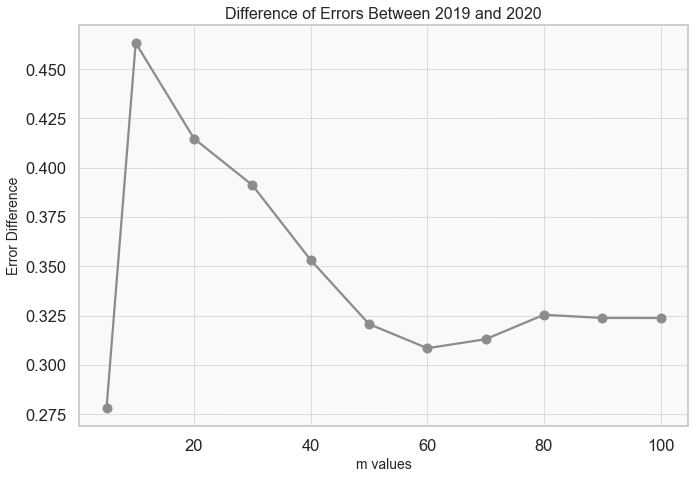

In [26]:
import numpy as np
import matplotlib.pyplot as plt

error_diff = abs(np.subtract(output['error_2020'], output['error_2019']))

# Setting up the figure and axis
plt.figure(figsize=(10, 7))
ax = plt.gca()

# Color
line_color_diff = '#8c8c8c'  # Soft gray

# Plotting for error difference
plt.plot(output['m'], error_diff, marker='o', linestyle='-', color=line_color_diff)

# Styling and annotations
plt.xlabel('m values', fontsize=14)
plt.ylabel('Error Difference', fontsize=14)
plt.title('Difference of Errors Between 2019 and 2020', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='#aaaaaa')
ax.set_facecolor('#f9f9f9')

plt.tight_layout()
plt.show()

### Comparing original and new method

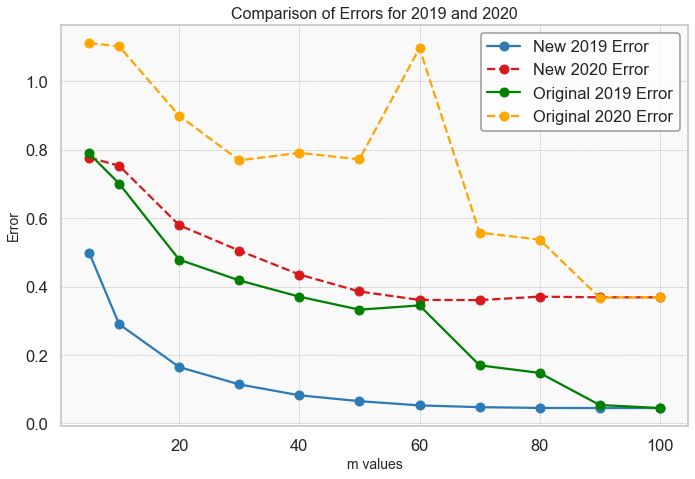

In [27]:
import matplotlib.pyplot as plt

# Variables
m_indexes = output['m']
new_2019_error = output['error_2019']
new_2020_error = output['error_2020']

# Setting up the figure and axis
plt.figure(figsize=(10, 7))
ax = plt.gca()

# Colors
line_color_2019 = '#2c7bb6'  # Soft blue
line_color_2020 = '#d7191c'  # Soft red

# Plotting for new_2019_error
plt.plot(m_indexes, new_2019_error, marker='o', linestyle='-', color=line_color_2019, label='New 2019 Error')

# Plotting for new_2020_error
plt.plot(m_indexes, new_2020_error, marker='o', linestyle='--', color=line_color_2020, label='New 2020 Error')

# Plotting for error_2019_comp
plt.plot(m_indexes, errors_2019_comp, marker='o', linestyle='-', color='green', label='Original 2019 Error')

# Plotting for error_2020_comp
plt.plot(m_indexes, errors_2020_comp, marker='o', linestyle='--', color='orange', label='Original 2020 Error')

# Styling and annotations
plt.xlabel('m values', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title('Comparison of Errors for 2019 and 2020', fontsize=16)
plt.legend(frameon=True, edgecolor='gray')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='#aaaaaa')
ax.set_facecolor('#f9f9f9')

plt.tight_layout()


# Show the plot
plt.show()

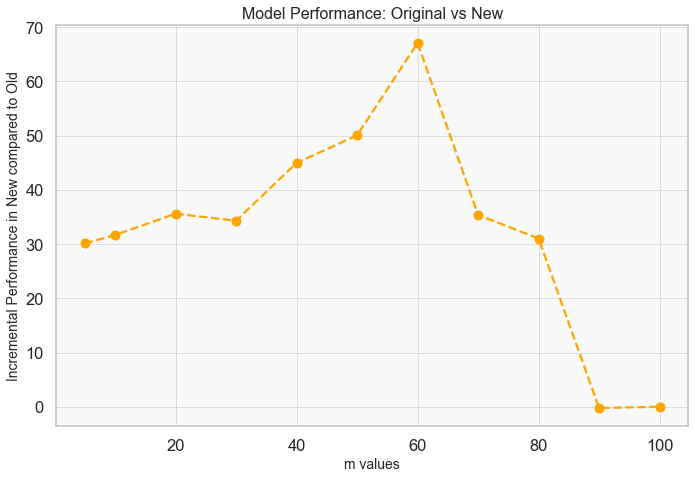

In [31]:
# Variables
per_change = ((errors_2020_comp - new_2020_error) * 100) / errors_2020_comp
m_axis = [5] + [i for i in range(10, min(101, n+1), 10)]

# Setting up the figure and axis
plt.figure(figsize=(10, 7))
ax = plt.gca()

# Colors
line_color_orange = 'orange'  # Orange

# Plotting for per_change without label
plt.plot(m_axis, per_change, marker='o', linestyle='--', color=line_color_orange)

# Styling and annotations
plt.xlabel('m values', fontsize=14)
plt.ylabel('Incremental Performance in New compared to Old', fontsize=14)
plt.title('Model Performance: Original vs New', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='#aaaaaa')
ax.set_facecolor('#f9f9f9')

plt.tight_layout()
plt.savefig('Performance.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="arial" size="4"> 

In summary, our new approach demonstrates superior performance compared to our original strategy, with notably lower test errors. What's more, the test error consistently mirrors the training error pattern, underscoring the effectiveness of our portfolio in tracking returns.

In contrast, the original approach exhibits elevated test errors within the range of m values from 10 to 90. For m values of 90-100, the performance remains similar between the two approaches.

Additionally, the new approach achieves even lower training error compared to the old approach, and it stands out for its remarkable stability without the spikes observed in the original method. This reliability enables the new approach to effectively track the stock index.

In conclusion, our new approach excels in tracking the stock index and performs significantly better, particularly for portfolios with a number of stocks ranging from 10 to 90.
 
</font>
</div>



### Acknowledgements

For assistance with data visualization and related code in this notebook, we referred ChatGPT, lecture slides, and notebooks.